In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
import itertools
import math
from sklearn.model_selection import train_test_split, KFold
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop, Adagrad

In [3]:
#Reading the data
train = pd.read_csv("/content/sample_data/mnist_train_small.csv")
test = pd.read_csv("/content/sample_data/mnist_test.csv")

In [4]:
#Training data head
train.head()

,6,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,...,0.551,0.552,0.553,0.554,0.555,0.556,0.557,0.558,0.559,0.560,0.561,0.562,0.563,0.564,0.565,0.566,0.567,0.568,0.569,0.570,0.571,0.572,0.573,0.574,0.575,0.576,0.577,0.578,0.579,0.580,0.581,0.582,0.583,0.584,0.585,0.586,0.587,0.588,0.589,0.590
0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
#Specifying train and test data
train_X = train.iloc[:,1:]
train_y = train.iloc[:,0]
test = test.iloc[:,1:]


In [6]:
#Shape of the specified data
print(train_X.shape)
print(train_y.shape)
print(test.shape)

(19999, 784)
(19999,)
(9999, 784)


In [7]:
#Normalize the data
train_X = train_X / 255.0
test = test / 255.0

In [8]:
#Reshape image in 3 dimensions (with 1 channel)
train_X = train_X.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [9]:
#Encode labels to one hot vectors
train_y = to_categorical(train_y, num_classes = 10)

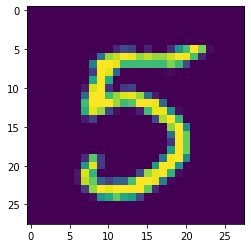

In [10]:
#Sample image
plt.imshow(train_X[0][:,:,0])

In [11]:
'''Ensemble Of Convolutional Neural Networks'''

'Ensemble Of Convolutional Neural Networks'

In [16]:
# Define 10 CNN models
from keras.optimizers import RMSprop, Adam
from keras.layers import DepthwiseConv2D, Reshape, Activation

nets = 10
model = [0] *nets

for j in range(nets):
    model[j] = Sequential()
    #First Layer
    model[j].add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))


     #Second Layer
    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    #Third layer
    model[j].add(Conv2D(128, kernel_size = 4, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Flatten())
    model[j].add(Dropout(0.4))

    #Output layer
    model[j].add(Dense(10, activation='softmax'))

    # Compile each model
    model[j].compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])

    
print('All Models Defined')

All Models Defined


In [17]:
#LR Reduction Callback
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction=ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=0, factor=0.5, min_lr=0.00001)

In [18]:
# train for 20 epochs
history = [0] * nets
epochs = 20

datagen = ImageDataGenerator(rotation_range=13, zoom_range=0.11, width_shift_range=0.1, height_shift_range=0.1)

datagen.fit(train_X)

for j in range(nets):
    print(f'Individual Net : {j+1}')   
    X_train2, X_val2, Y_train2, Y_val2 = train_test_split(train_X, train_y, test_size = 0.1)
    history[j] = model[j].fit_generator(datagen.flow(X_train2,Y_train2, batch_size=64), epochs = epochs, steps_per_epoch = X_train2.shape[0]//64, validation_data = (X_val2,Y_val2), callbacks=[learning_rate_reduction], verbose=0)

    print("CNN Model {0:d}: Epochs={1:d}, Training accuracy={2:.5f}, Validation accuracy={3:.5f}".format(j+1,epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))

Individual Net : 1


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


CNN Model 1: Epochs=20, Training accuracy=0.98796, Validation accuracy=0.99500
Individual Net : 2
CNN Model 2: Epochs=20, Training accuracy=0.98801, Validation accuracy=0.99500
Individual Net : 3
CNN Model 3: Epochs=20, Training accuracy=0.98991, Validation accuracy=0.99500
Individual Net : 4
CNN Model 4: Epochs=20, Training accuracy=0.98829, Validation accuracy=0.99500
Individual Net : 5
CNN Model 5: Epochs=20, Training accuracy=0.98963, Validation accuracy=0.99600
Individual Net : 6
CNN Model 6: Epochs=20, Training accuracy=0.98907, Validation accuracy=0.99450
Individual Net : 7
CNN Model 7: Epochs=20, Training accuracy=0.98913, Validation accuracy=0.99500
Individual Net : 8
CNN Model 8: Epochs=20, Training accuracy=0.98863, Validation accuracy=0.99650
Individual Net : 9
CNN Model 9: Epochs=20, Training accuracy=0.98824, Validation accuracy=0.99300
Individual Net : 10
CNN Model 10: Epochs=20, Training accuracy=0.98896, Validation accuracy=0.99650


In [19]:
#Result
results = np.zeros( (test.shape[0],10) ) 
for j in range(nets):
    results = results + model[j].predict(test)
 
results = np.argmax(results,axis = 1)

Text(0.5, 1.0, '2')

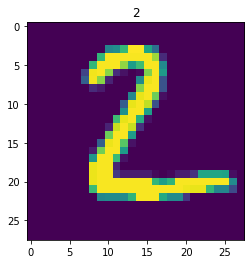

In [20]:
#Test on result
plt.imshow(test[0][:,:,0])
plt.title(results[0])

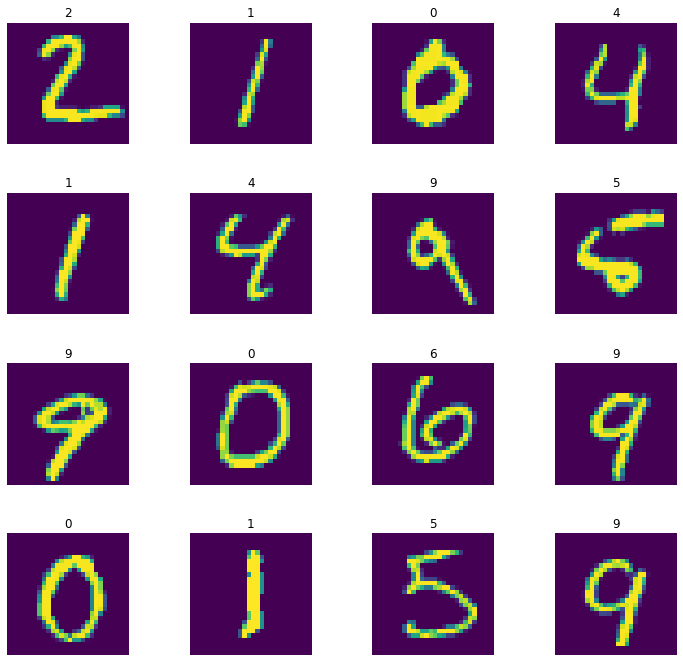

In [21]:
L = 4
W = 4
fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L * W):  
    axes[i].imshow(test[i].reshape(28,28))
    axes[i].set_title(results[i])
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)